In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook',ticks=True, grid=False)
import warnings
warnings.filterwarnings('ignore')
#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
#feature engineering
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
#evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
#saving models
import pickle

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Metrics Selection
    
    TP : If the model predict stroke, and actual is stroke : early treatment to prevent stroke
    TN : If the model predict false stroke, and actual is false stroke : safe
    FP : If the model predict stroke, but actual is false stroke : panic
    FN : If the model predict false stroke, but actual is stroke : stroke because not getting 
    an early treatment
    
Here I want to focus more on preveting FN, which means I will be using Recall

In [3]:
round(df.isna().sum()/len(df.index)*100, 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

In [4]:
df.drop(['id'], axis = 1, inplace = True)

In [5]:
df.drop(df.loc[df['gender']=='Other'].index, inplace=True)

In [6]:
x = df.drop(['stroke'], axis = 1)
y = df['stroke']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 2021)

# Model Selection

    DecisionTree
    Logistric Regression
    KNN

In [8]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [9]:
df['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

    I will be making 2 different transformer base on the way I fill the missing values in BMI which will be mean and median

In [10]:
one_hot = OneHotEncoder(drop = 'first')
binary = BinaryEncoder()
imputer_mean = SimpleImputer(strategy = 'mean')
imputer_medi = SimpleImputer(strategy = 'median')

transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_mean, ['bmi'])
], remainder = 'passthrough')

transformer_medi = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_medi, ['bmi'])
], remainder = 'passthrough')

In [11]:
logreg = LogisticRegression(solver = 'liblinear')
tree = DecisionTreeClassifier(random_state = 2021)
knn = KNeighborsClassifier()

In [12]:
################################################################################################################################

In [13]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1458
           1       0.14      0.17      0.15        75

    accuracy                           0.91      1533
   macro avg       0.55      0.56      0.55      1533
weighted avg       0.92      0.91      0.91      1533



In [14]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.07      0.01      0.02        75

    accuracy                           0.94      1533
   macro avg       0.51      0.50      0.50      1533
weighted avg       0.91      0.94      0.92      1533



In [15]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [16]:
################################################################################################################################

In [17]:
estimatortree = Pipeline([
    ('transformer', transformer_medi),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1458
           1       0.15      0.19      0.17        75

    accuracy                           0.91      1533
   macro avg       0.55      0.57      0.56      1533
weighted avg       0.92      0.91      0.91      1533



In [18]:
estimatorknn = Pipeline([
    ('transformer', transformer_medi),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.07      0.01      0.02        75

    accuracy                           0.94      1533
   macro avg       0.51      0.50      0.50      1533
weighted avg       0.91      0.94      0.92      1533



In [19]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_medi),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



In [20]:
################################################################################################################################

In [21]:
def model_evaluation_cv_mean(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [22]:
def model_evaluation_cv_medi(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_medi),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [23]:
def print_result(model_cv):
    print('score : ', model_cv)
    print('mean score : ', model_cv.mean())
    print('std score : ', model_cv.std())

In [88]:
model_cv = model_evaluation_cv_mean(tree)
print_result(model_cv)

score :  [0.22857143 0.26470588 0.17142857 0.11428571 0.17142857]
mean score :  0.19008403361344542
std score :  0.0519444657909256


In [87]:
model_cv = model_evaluation_cv_medi(tree)
print_result(model_cv)

score :  [0.22857143 0.17647059 0.2        0.11428571 0.17142857]
mean score :  0.17815126050420171
std score :  0.0378057878292504


In [26]:
model_cv = model_evaluation_cv_mean(knn)
print_result(model_cv)

score :  [0.         0.02941176 0.02857143 0.         0.05714286]
mean score :  0.023025210084033614
std score :  0.021428406656146863


In [27]:
model_cv = model_evaluation_cv_medi(knn)
print_result(model_cv)

score :  [0.         0.         0.         0.         0.05714286]
mean score :  0.011428571428571429
std score :  0.022857142857142857


In [28]:
model_cv = model_evaluation_cv_mean(logreg)
print_result(model_cv)

score :  [0. 0. 0. 0. 0.]
mean score :  0.0
std score :  0.0


In [29]:
model_cv = model_evaluation_cv_medi(logreg)
print_result(model_cv)

score :  [0. 0. 0. 0. 0.]
mean score :  0.0
std score :  0.0


# Conclusion #1

    Impute the missing values by Mean is better than Median

In [30]:
################################################################################################################################

In [31]:
poly_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Poly', PolynomialFeatures(degree = 3, interaction_only = False, include_bias = False))
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Polynomial', poly_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [32]:
def model_evaluation_cv_mean_poly(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [33]:
model_cv = model_evaluation_cv_mean_poly(logreg)
print_result(model_cv)

score :  [0.02857143 0.         0.         0.05714286 0.        ]
mean score :  0.017142857142857144
std score :  0.022857142857142857


In [34]:
features=list(transformer_mean.transformers_[0][1].get_feature_names()) + transformer_mean.transformers_[1][1].get_feature_names() + [
    'age','hypertension','heart_disease','avg_glucose_level','bmi']
features

['x0_Male',
 'x1_Yes',
 'x2_Urban',
 'work_type_0',
 'work_type_1',
 'work_type_2',
 'work_type_3',
 'smoking_status_0',
 'smoking_status_1',
 'smoking_status_2',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi']

In [35]:
importance_table=pd.DataFrame({
    'imp': tree.feature_importances_
}, index=features)

In [36]:
importance_table

,imp
x0_Male,0.023243
x1_Yes,0.028930
x2_Urban,0.031268
work_type_0,0.000000
work_type_1,0.000000
work_type_2,0.012535
work_type_3,0.029797
smoking_status_0,0.014847
smoking_status_1,0.022411
smoking_status_2,0.028513


<AxesSubplot:>

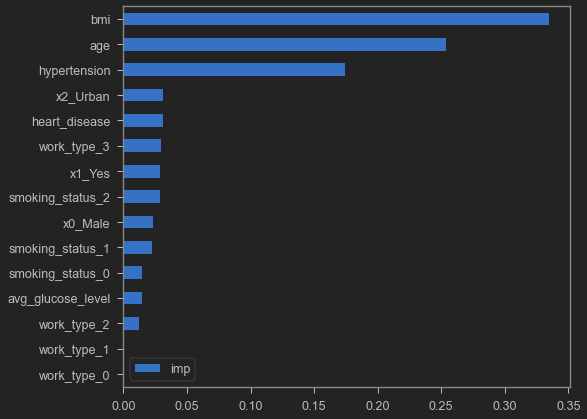

In [37]:
importance_table.sort_values('imp').plot(kind='barh')

# oversampling/undersampling dulu

# feature selection diawal

In [38]:
randomover = RandomOverSampler(random_state = 2021)
randomunder = RandomUnderSampler(random_state = 2021)
smote = SMOTE(random_state = 2021)
nearmiss = NearMiss()

In [39]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomover),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [40]:
def model_evaluation_cv_mean_under(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomunder),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [41]:
def model_evaluation_cv_mean_smote(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', smote),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [42]:
def model_evaluation_cv_mean_near(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', nearmiss),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [43]:
model_cv = model_evaluation_cv_mean_over(tree)
print_result(model_cv)

score :  [0.08571429 0.26470588 0.02857143 0.11428571 0.05714286]
mean score :  0.11008403361344536
std score :  0.08242151149740658


In [44]:
model_cv = model_evaluation_cv_mean_under(tree)
print_result(model_cv)

score :  [0.65714286 0.55882353 0.71428571 0.71428571 0.77142857]
mean score :  0.6831932773109244
std score :  0.07192413362081414


In [45]:
model_cv = model_evaluation_cv_mean_smote(tree)
print_result(model_cv)

score :  [0.2        0.17647059 0.11428571 0.11428571 0.2       ]
mean score :  0.16100840336134453
std score :  0.03910444406165481


In [46]:
model_cv = model_evaluation_cv_mean_near(tree)
print_result(model_cv)

score :  [0.74285714 0.79411765 0.74285714 0.68571429 0.77142857]
mean score :  0.7473949579831933
std score :  0.036349176368882644


In [47]:
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.71428571 0.79411765 0.68571429 0.88571429 0.82857143]
mean score :  0.7816806722689076
std score :  0.07338670425214266


In [48]:
model_cv = model_evaluation_cv_mean_under(logreg)
print_result(model_cv)

score :  [0.77142857 0.76470588 0.74285714 0.8        0.77142857]
mean score :  0.7700840336134454
std score :  0.018269147215732705


In [49]:
model_cv = model_evaluation_cv_mean_smote(logreg)
print_result(model_cv)

score :  [0.74285714 0.79411765 0.68571429 0.88571429 0.82857143]
mean score :  0.7873949579831934
std score :  0.06889116427128314


In [50]:
model_cv = model_evaluation_cv_mean_near(logreg)
print_result(model_cv)

score :  [0.6        0.70588235 0.51428571 0.6        0.54285714]
mean score :  0.5926050420168066
std score :  0.06565042352407652


In [51]:
model_cv = model_evaluation_cv_mean_over(knn)
print_result(model_cv)

score :  [0.37142857 0.32352941 0.31428571 0.42857143 0.31428571]
mean score :  0.35042016806722687
std score :  0.04446005579143296


In [52]:
model_cv = model_evaluation_cv_mean_under(knn)
print_result(model_cv)

score :  [0.8        0.85294118 0.8        0.82857143 0.82857143]
mean score :  0.8220168067226892
std score :  0.020058526047510152


In [96]:
model_cv = model_evaluation_cv_mean_smote(knn)
print_result(model_cv)

score :  [0.45714286 0.47058824 0.57142857 0.57142857 0.45714286]
mean score :  0.5055462184873949
std score :  0.05401629425640515


In [75]:
model_cv = model_evaluation_cv_mean_near(knn)
print_result(model_cv)

score :  [0.51428571 0.70588235 0.48571429 0.62857143 0.65714286]
mean score :  0.5983193277310924
std score :  0.084482832914563


# Conclusion #2

    RandomOverSampler = Best : Logreg(mean score :  0.781, std score :  0.073)
    RandomUnderSampler = Best : KNN(mean score :  0.822, std score :  0.020)
    SMOTE = Best : Logreg(mean score :  0.787, std score :  0.068)
    NearMiss = Best : Tree(mean score :  0.747, std score :  0.036)

# RANDOM OVER

In [55]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.88      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [56]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1458
           1       0.17      0.17      0.17        75

    accuracy                           0.92      1533
   macro avg       0.57      0.57      0.57      1533
weighted avg       0.92      0.92      0.92      1533



In [57]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomover),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1458
           1       0.13      0.37      0.19        75

    accuracy                           0.85      1533
   macro avg       0.55      0.62      0.55      1533
weighted avg       0.92      0.85      0.88      1533



# Random Under

In [58]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.85      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.78      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [59]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1458
           1       0.10      0.73      0.18        75

    accuracy                           0.68      1533
   macro avg       0.54      0.70      0.49      1533
weighted avg       0.94      0.68      0.77      1533



In [60]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', randomunder),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.78      1458
           1       0.11      0.85      0.20        75

    accuracy                           0.66      1533
   macro avg       0.55      0.75      0.49      1533
weighted avg       0.95      0.66      0.75      1533



# SMOTE

In [61]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1458
           1       0.13      0.83      0.23        75

    accuracy                           0.73      1533
   macro avg       0.56      0.78      0.53      1533
weighted avg       0.95      0.73      0.81      1533



In [62]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1458
           1       0.09      0.12      0.11        75

    accuracy                           0.90      1533
   macro avg       0.52      0.53      0.53      1533
weighted avg       0.91      0.90      0.91      1533



In [63]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', smote),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1458
           1       0.12      0.59      0.20        75

    accuracy                           0.77      1533
   macro avg       0.55      0.68      0.53      1533
weighted avg       0.93      0.77      0.84      1533



# Near Miss

In [65]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.29      0.44      1458
           1       0.04      0.63      0.08        75

    accuracy                           0.30      1533
   macro avg       0.49      0.46      0.26      1533
weighted avg       0.89      0.30      0.42      1533



In [66]:
estimatortree = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', tree)])
estimatortree.fit(x_train, y_train)
y_pred = estimatortree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.21      0.35      1458
           1       0.04      0.68      0.08        75

    accuracy                           0.24      1533
   macro avg       0.49      0.45      0.21      1533
weighted avg       0.89      0.24      0.33      1533



In [103]:
estimatorknn = Pipeline([
    ('transformer', transformer_mean),
    ('balancing', nearmiss),
    ('model', knn)])
estimatorknn.fit(x_train, y_train)
y_pred = estimatorknn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.24      0.38      1458
           1       0.04      0.63      0.08        75

    accuracy                           0.26      1533
   macro avg       0.48      0.43      0.23      1533
weighted avg       0.88      0.26      0.36      1533



# Conclusion #3
    
    

In [100]:
def model_evaluation_cv_mean_overall():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', transformer_mean),
            ('balancing', imbalance_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_overall()            

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.77,0.78,0.79,0.59
1,tree,0.68,0.11,0.16,0.75
2,knn,0.82,0.35,0.51,0.60


In [102]:
def overall_func():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean),
                ('balancing', imbalance_method[i]),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(round(recall_score(y_test, y_pred),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison
overall_func()

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.85,0.88,0.83,0.63
1,tree,0.73,0.17,0.12,0.68
2,knn,0.85,0.37,0.59,0.63


    
    RANDOM UNDER :
        logreg : 0.77 -> 0.85
        tree : 0.68 -> 0.73
        knn : 0.82 -> 0.85
    RANDOM OVER :
        logreg : 0.78 -> 0.88
        tree : 0.11 -> 0.17
        knn : 0.35 -> 0.37
    SMOTE :
        logreg : 0.77 -> 0.83
        tree : 0.16 -> 0.12
        knn : 0.51 -> 0.59
    NEARMISS :
        logreg : 0.59 -> 0.63
        tree : 0.75 -> 0.68
        knn : 0.60 -> 0.63
        
# Overall Best among the rest goes to Random Over Logreg with score of 0.88

In [68]:
################################################################################################################################

In [104]:
poly_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Poly', PolynomialFeatures(degree = 3, interaction_only = False, include_bias = False))
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Polynomial', poly_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [106]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('balancing', randomover),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [107]:
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.28571429 0.64705882 0.25714286 0.45714286 0.28571429]
mean score :  0.38655462184873945
std score :  0.14827682872447198


In [105]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean_logreg),
    ('balancing', randomover),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1458
           1       0.13      0.41      0.20        75

    accuracy                           0.84      1533
   macro avg       0.55      0.64      0.56      1533
weighted avg       0.93      0.84      0.88      1533



    
    Tidak tau kenapa ketika di polynomial, nilainya turun banyak, entah karena cara saya salah atau emang demikian

In [108]:
################################################################################################################################

In [110]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [114]:
def model_evaluation_cv_mean_over(model):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('balancing', randomover),
    ('model', model)
])
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
    return model_cv

In [115]:
model_cv = model_evaluation_cv_mean_over(logreg)
print_result(model_cv)

score :  [0.71428571 0.82352941 0.68571429 0.88571429 0.82857143]
mean score :  0.787563025210084
std score :  0.07530162027446238


In [113]:
estimatorlogreg = Pipeline([
    ('transformer', transformer_mean_logreg),
    ('balancing', randomover),
    ('model', logreg)])
estimatorlogreg.fit(x_train, y_train)
y_pred = estimatorlogreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.87      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533




    Sama juga kalau dilakukan scaling, nilainya turun sedikit yaitu 0.01